In [1]:
%%html
<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsx.otf');
        font-weight: bold;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsi.otf');
        font-style: italic, oblique;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunbxo.otf');
        font-weight: bold;
        font-style: italic, oblique;
    }
    .text_cell { font-family: "Computer Modern", "Palatino", "Palatino Linotype", serif; }
    .code_cell:first-child { display: none; } 
    h1, h2, h3, h4 { text-align: center; }
</style>

# Chaotic Behavior of the Triple Pendulum
## A Computational Approach

#### Rachel Bass and Cory McCartan

In [1]:
%%capture

# Set-up and formatting

%pylab inline
from scipy.integrate import odeint 
from scipy.interpolate import UnivariateSpline
from matplotlib import animation

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print out value of variable without needing print statement
%config InlineBackend.figure_format = "retina"  # higher-def plots

## Setup

### Equations of Motion

We begin by defining the constants for our system. The equations of motion for the triple pendulum are 
\begin{equation}
\begin{pmatrix}
    \ddot\phi_1 \\
    \ddot\phi_2 \\
    \ddot\phi_3
\end{pmatrix} = \begin{pmatrix}
    3                    & 2\cos(\phi_1-\phi_2) & \cos(\phi_1-\phi_3) \\
    2\cos(\phi_1-\phi_2) & 2                    & \cos(\phi_2-\phi_3) \\
    \cos(\phi_1-\phi_3)  & \cos(\phi_2-\phi_3)  & 1                   \\
\end{pmatrix}^{-1}
\begin{pmatrix}
    -\dot\phi_3^2\sin(\phi_1-\phi_3) -2\dot\phi_2^2\sin(\phi_1-\phi_2)
        -\frac{3g}{l}\sin\phi_1 \\
    -\dot\phi_3^2\sin(\phi_2-\phi_3) + 2\dot\phi_1^2\sin(\phi_1-\phi_2)
        -\frac{2g}{l}\sin\phi_2 \\
    \dot\phi_2^2\sin(\phi_2-\phi_3) +\dot\phi_1^2\sin(\phi_1-\phi_3)
        -\frac{g}{l}\sin\phi_3
\end{pmatrix},
\end{equation}
which as we can see depend only on the angles and angular velocities of the masses, as well as $g$ and $l$.

In [2]:
# Constants
g = 9.8 # m/s^2
l = 0.5 # m

In [3]:
# Mechanics of triple pendulum system.
# Passed into odeint function.
def triple_pendulum(r, t, g, l):
    phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = r # unpack variables
    
    # precalculate trig functions
    cos_1_2 = cos(phi_1 - phi_2)
    cos_1_3 = cos(phi_1 - phi_3)
    cos_2_3 = cos(phi_2 - phi_3)
    sin_1_2 = sin(phi_1 - phi_2)
    sin_1_3 = sin(phi_1 - phi_3)
    sin_2_3 = sin(phi_2 - phi_3)
    
    # define arrays and vectors
    A = array([[3,         2*cos_1_2, cos_1_3],
               [2*cos_1_2, 2,         cos_2_3],
               [cos_1_3,   cos_2_3,   1      ]])
    
    B = array([-dphi_3**2 * sin_1_3 - 2*dphi_2**2 * sin_1_2 - 3*g*sin(phi_1)/l,
               -dphi_3**2 * sin_2_3 + 2*dphi_1**2 * sin_1_2 - 2*g*sin(phi_2)/l,
                dphi_2**2 * sin_2_3 +   dphi_1**2 * sin_1_3 -   g*sin(phi_3)/l])
    
    ddphi =  matmul(inv(A), B) # angular acceleration
    return concatenate(([dphi_1, dphi_2, dphi_3], ddphi)) # tack on angular velocity

In [4]:
def solve_triple_pendulum(r0, tmax, l=l, dt = 0.001):
    t = arange(0, tmax, dt)
    solution = odeint(triple_pendulum, r0, t, args = (g, l))
    
    
    phi_1 = solution[:, 0]
    phi_2 = solution[:, 1]
    phi_3 = solution[:, 2]
    
    dphi_1 = solution[:, 3]
    dphi_2 = solution[:, 4]
    dphi_3 = solution[:, 5]
    
    return t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3

### Plotting

We also create some helper functions to plot solutions to the triple pendulum system.  In addition to viewing the three angles over time, we'd like to be able to see the trajectories the masses trace out, as well as a phase space plot for each mass.

In [5]:
# Plots phi_1, phi_2, and phi_3 over time.
def time_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    deg_1 = phi_1 * 180 / pi
    deg_2 = phi_2 * 180 / pi
    deg_3 = phi_3 * 180 / pi
    
   
    figsize(15, 7)
    figure()
          
    plot(t, deg_1, "-g", label="First pendulum")
    plot(t, deg_2, "--m", label="Second pendulum")
    plot(t, deg_3, ":k", label="Third pendulum")
    # titles and labels
    title("Pendulum Angles over Time\n{}".format(subtitle))
    xlabel("Time (s)")
    ylabel("Angle (deg)")
    # legend
    legend()
    
    
# Plots the pendulum trajectory in x-y space. NOT scaled appropriately to length l
def trajectory_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    x1 = sin(phi_1)
    x2 = x1 + sin(phi_2)
    x3 = x2 + sin(phi_3)
    y1 = -cos(phi_1)
    y2 = y1 - cos(phi_2)
    y3 = y2 - cos(phi_3)
    
    figsize(15, 7)
    figure()
    
    axvline(x = 0, color = "#bbbbbb")#vertical light gray line
    axhline(y = 0, color = "#bbbbbb")#horizontal light gray line
    
    plot(x1, y1, "-g", label = "First Pendulum")
    plot(x2, y2, "--m", label = "Second Pendulum")
    plot(x3, y3, ":k", label = "Third Pendulum")
    
    title("Pendulum Trajectories over Time\n{}".format(subtitle))
    xlabel("x")
    ylabel("y")
    legend()
    
    margins(y = 0.1)
    
# Plots the phase space trajectories of the masses
def phase_space_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    fig = figure()
    title("Phase Space Trajectories of Masses\n{}\n\n".format(subtitle))
    axis("off")
    
    plot1 = fig.add_subplot(131)
    axvline(x = 0, color = "#bbbbbb")#vertical light gray line
    axhline(y = 0, color = "#bbbbbb")#horizontal light gray line
    plot(phi_1, dphi_1, "k")
    title("First Pendulum")
    xlabel("Angle")
    ylabel("Angular Velocity (1/s)")
    
    plot2 = fig.add_subplot(132)
    axvline(x = 0, color = "#bbbbbb")#vertical light gray line
    axhline(y = 0, color = "#bbbbbb")#horizontal light gray line
    plot(phi_2, dphi_2, "k")
    title("Second Pendulum")
    xlabel("Angle")
    
    plot3 = fig.add_subplot(133)
    axvline(x = 0, color = "#bbbbbb")#vertical light gray line
    axhline(y = 0, color = "#bbbbbb")#horizontal light gray line
    plot(phi_3, dphi_3, "k")
    title("Third Pendulum")
    xlabel("Angle")
    
    tight_layout()

## Verification

We want to check that the `triple_pendulum` function accurately captures the dynamic of the system. Since there is no analytic solution to the triple pendulum, we can do this by checking a few limiting cases, and checking that energy is conserved generally.

### No initial displacement or angular velocity

We first conduct a sanity check by ensuring that when $\phi_i=0$ and $\dot\phi_i=0$, the pendulum system remains motionless.

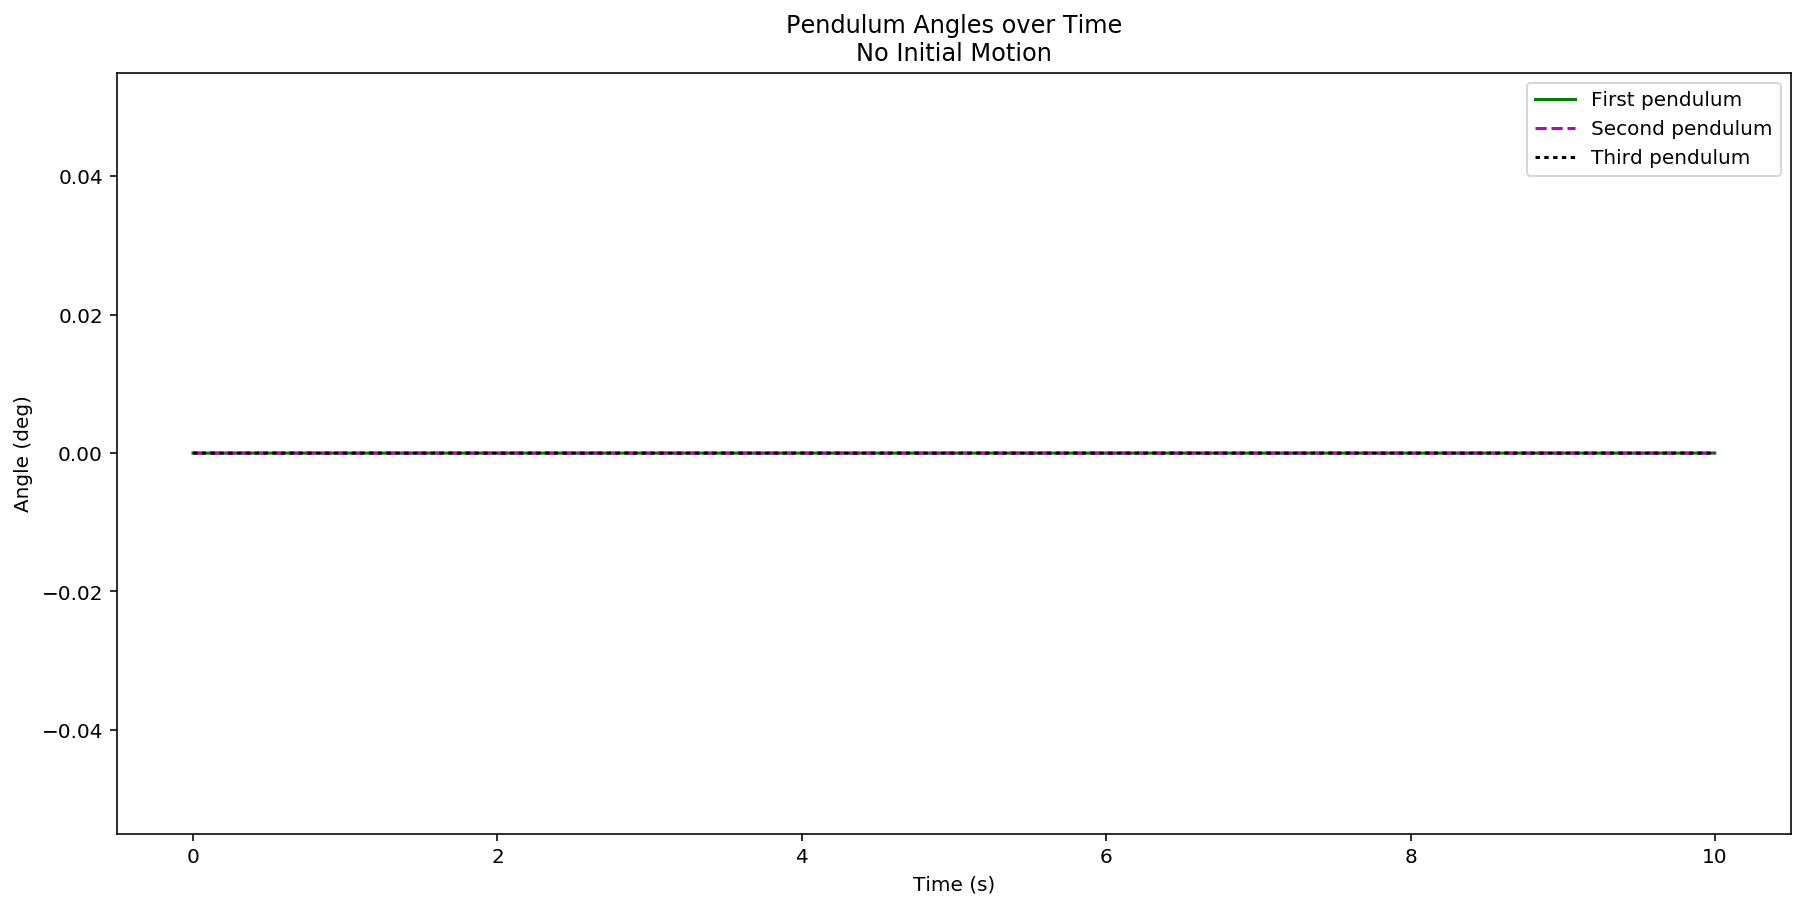

In [6]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 0], tmax=10)
time_plot(solution, "No Initial Motion")

### Energy Conservation

We can also check that energy is conserved.  We will start the bottom pendulum with a moderate amount of initial angular velocity ($\dot\phi_3=7\ s^{-1}$), but leave the other intial conditions unchanged.

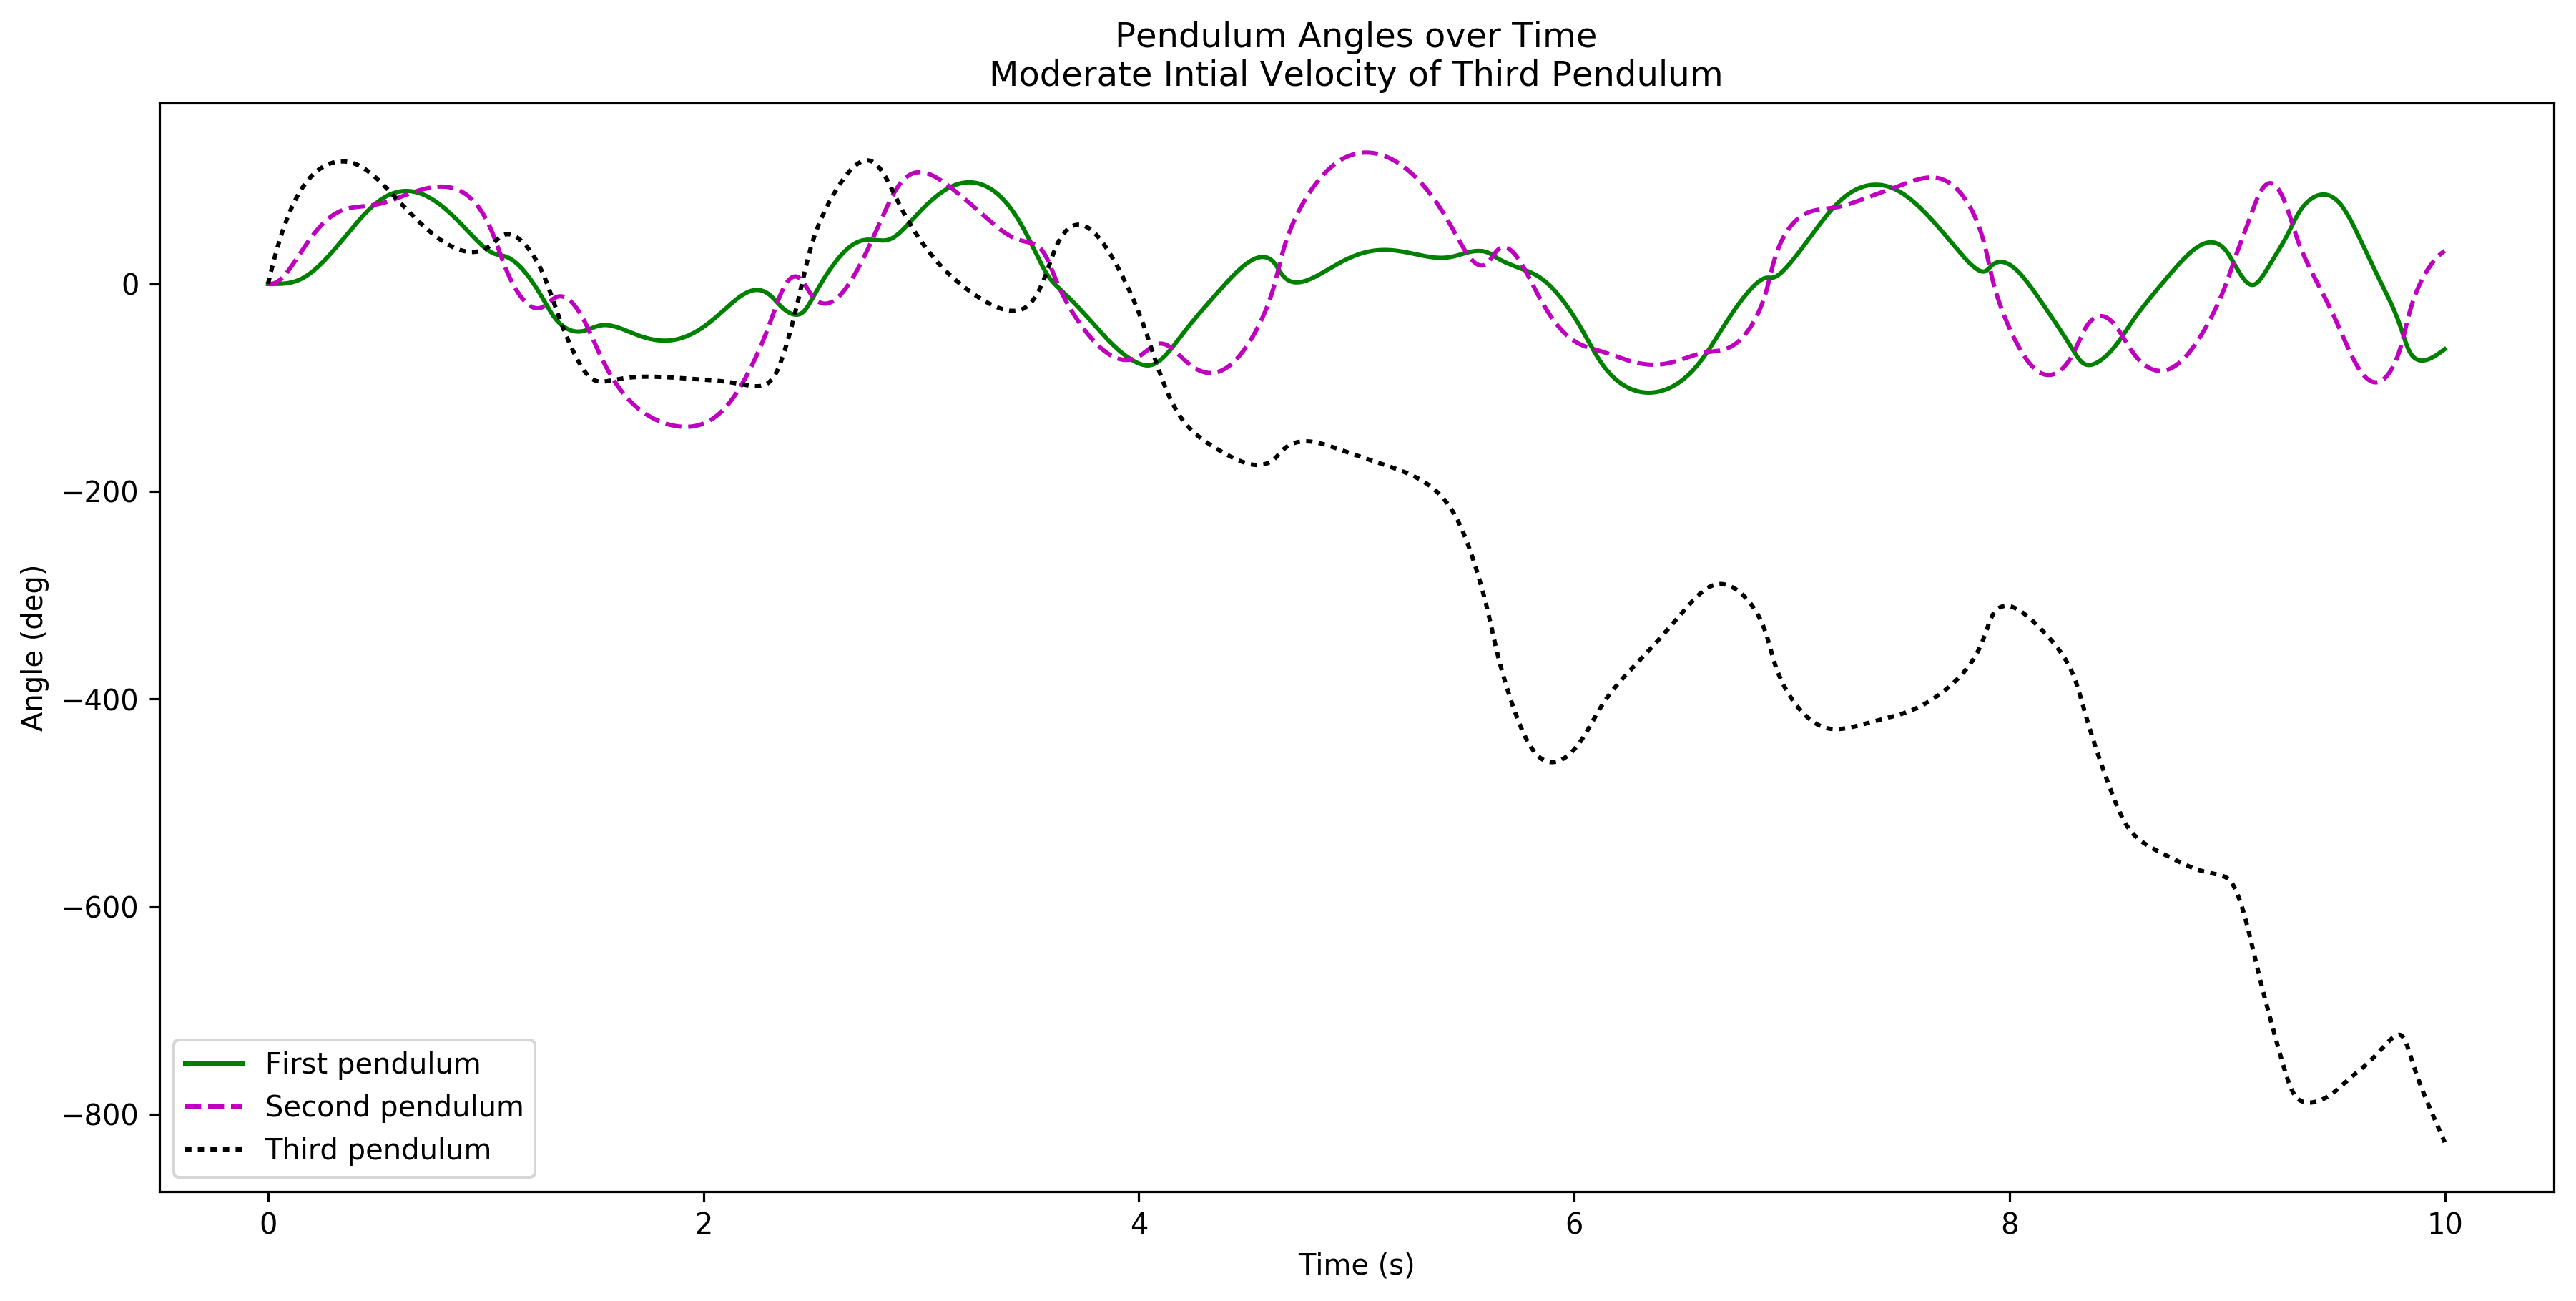

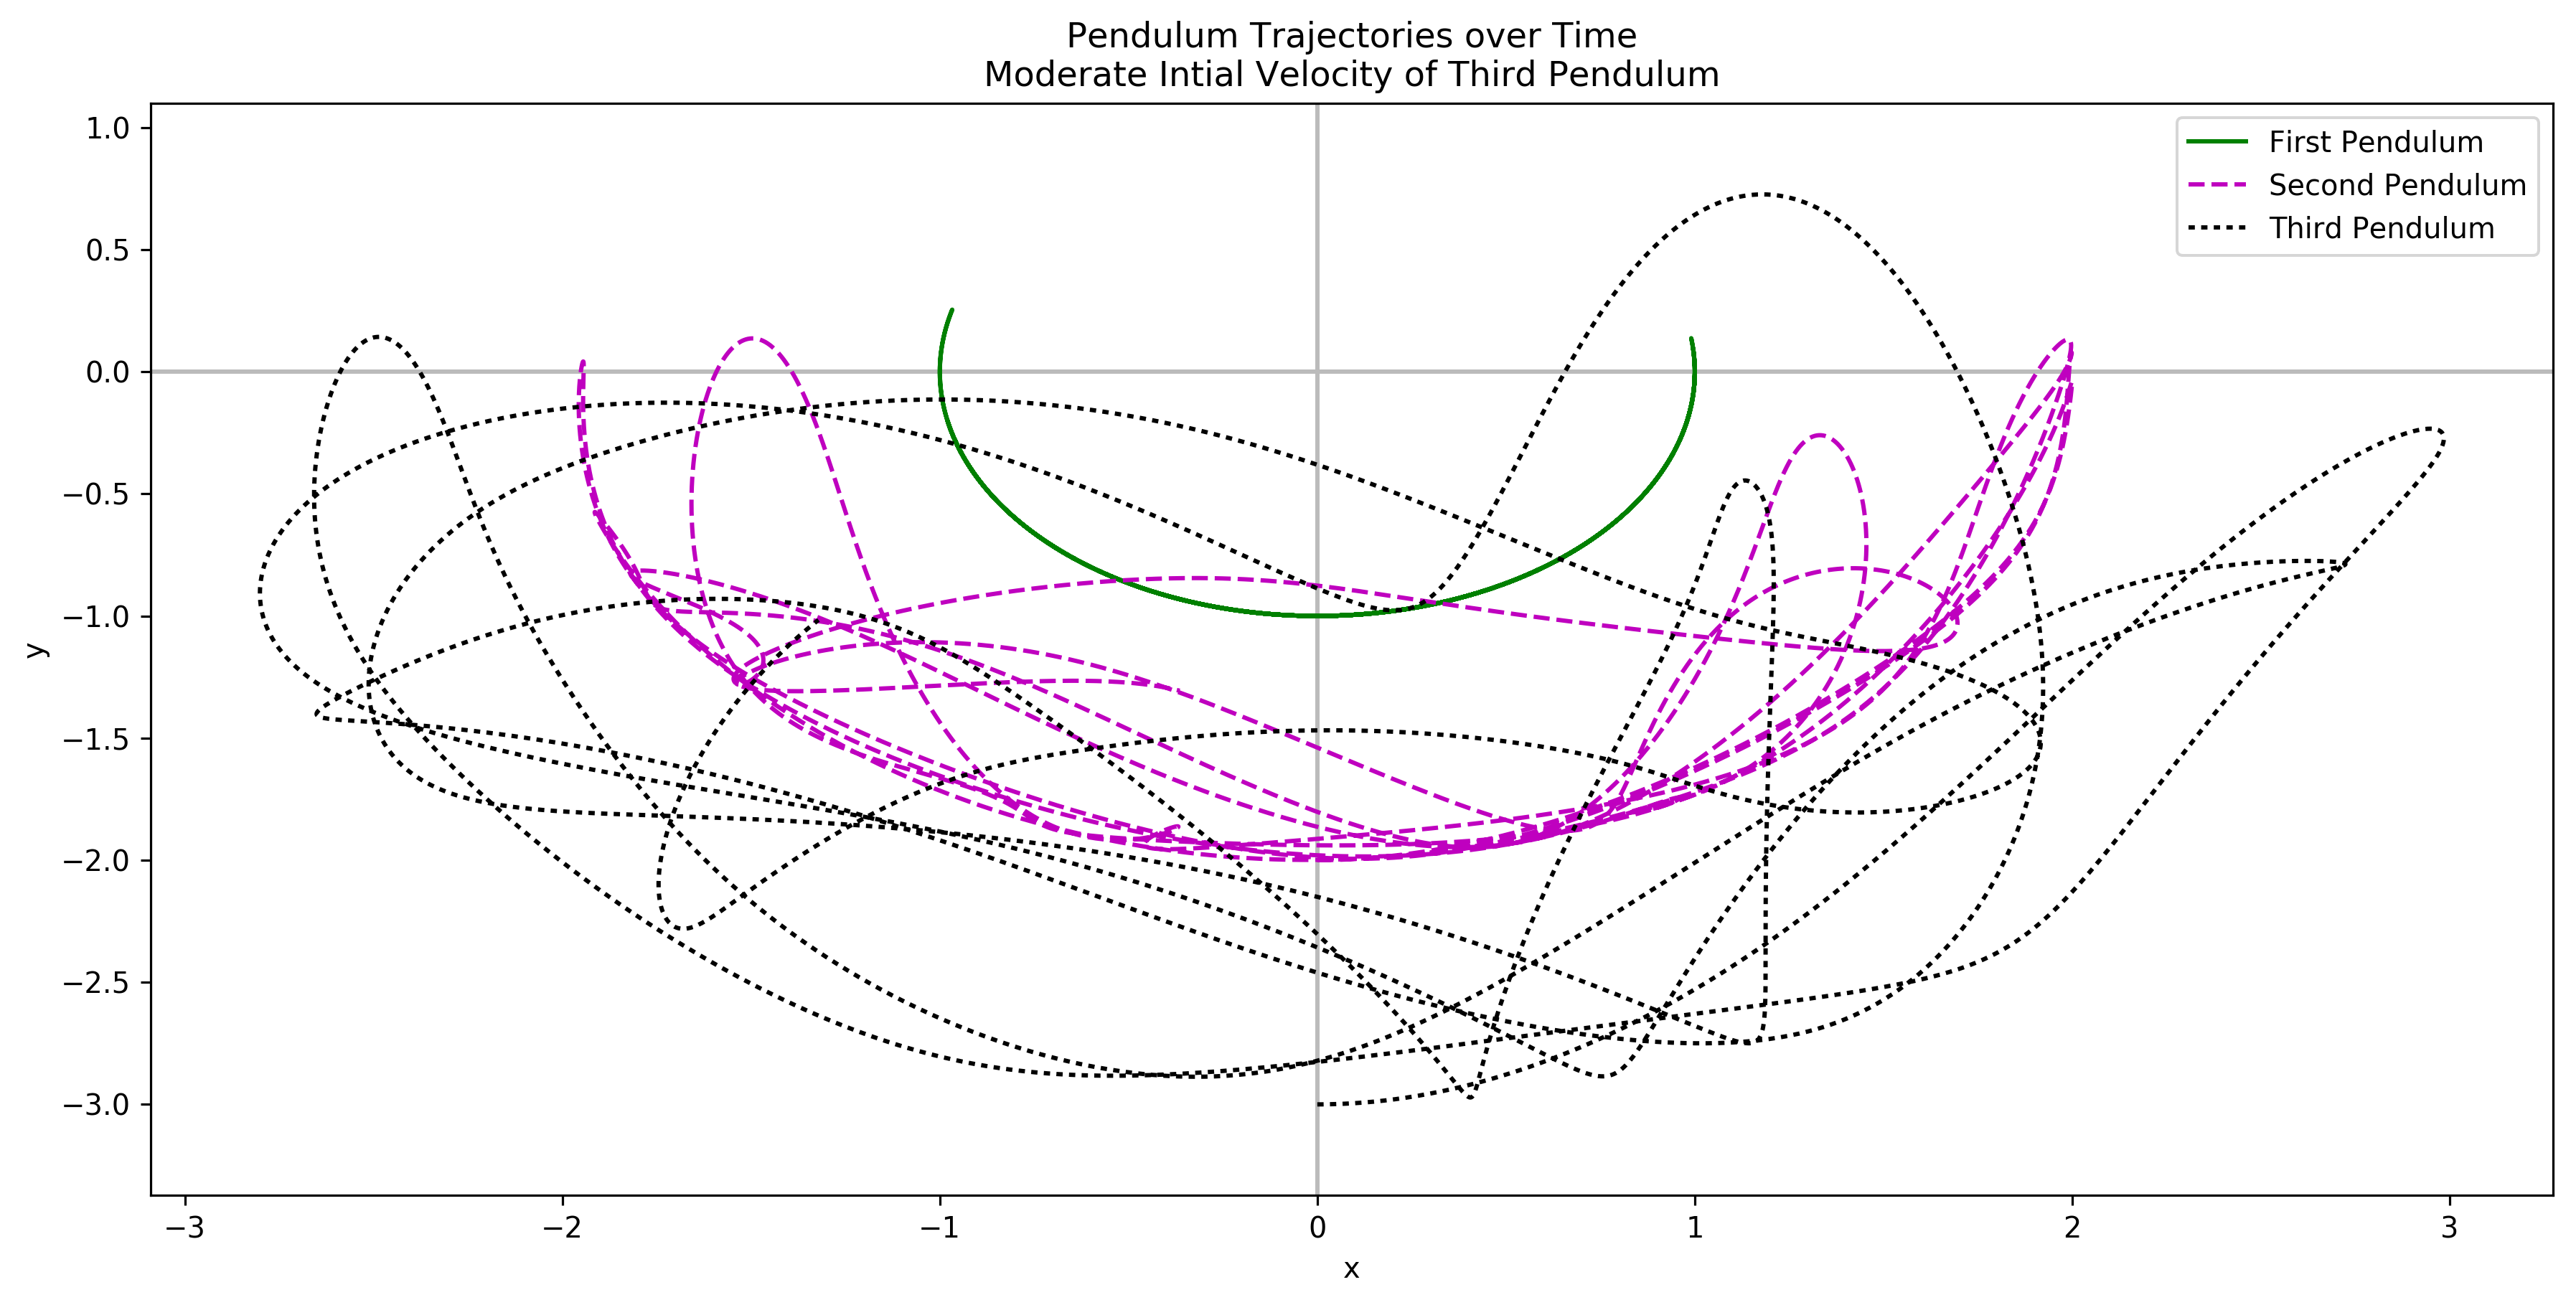

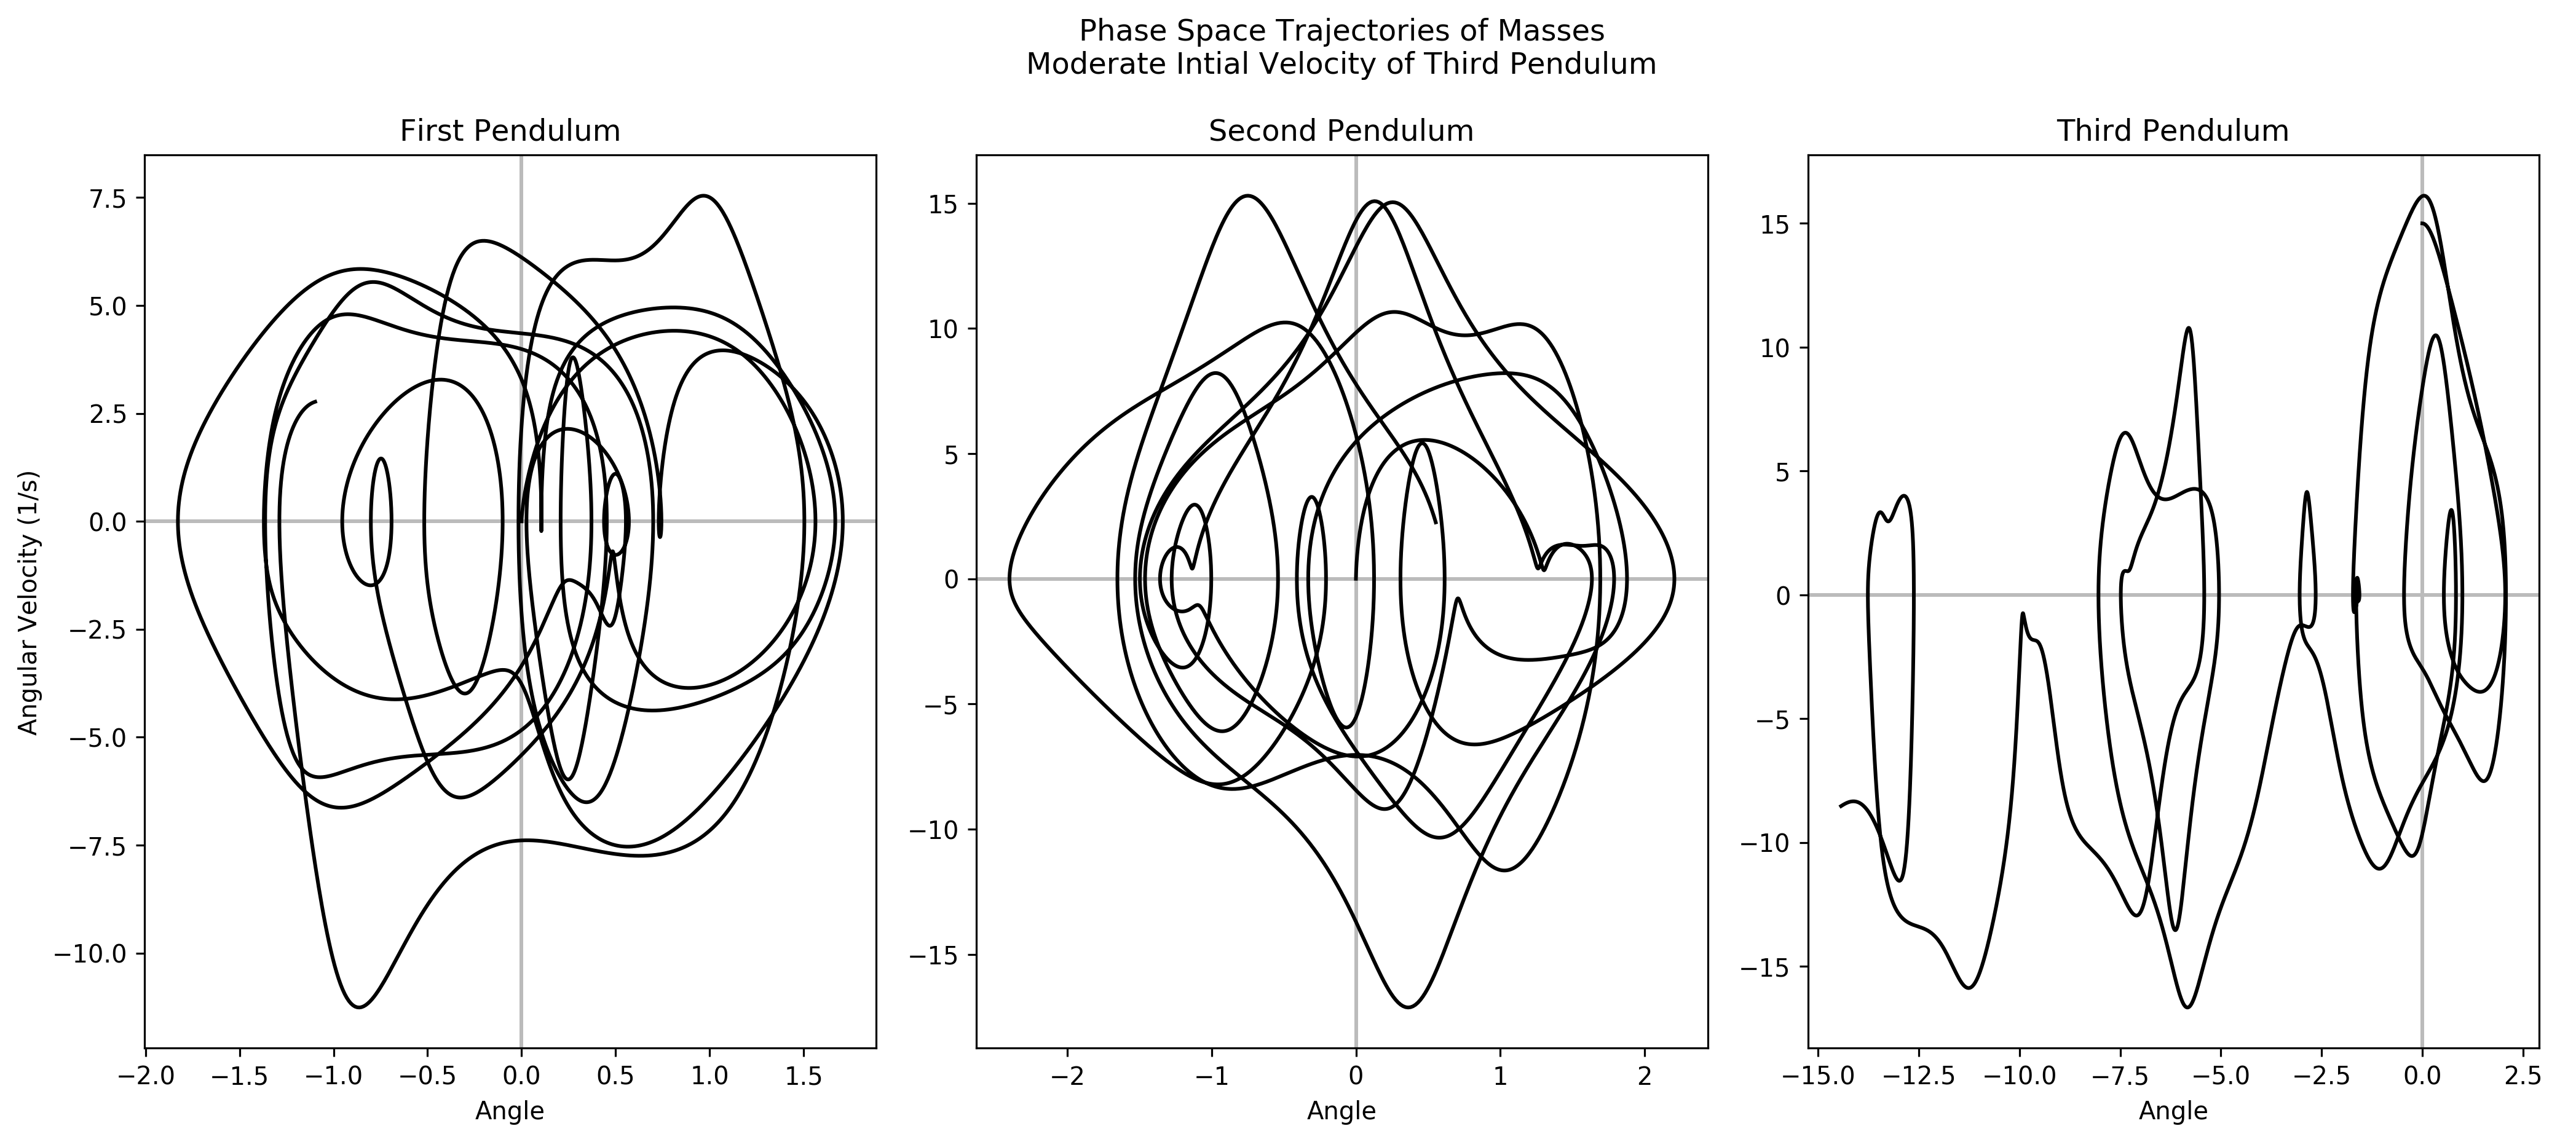

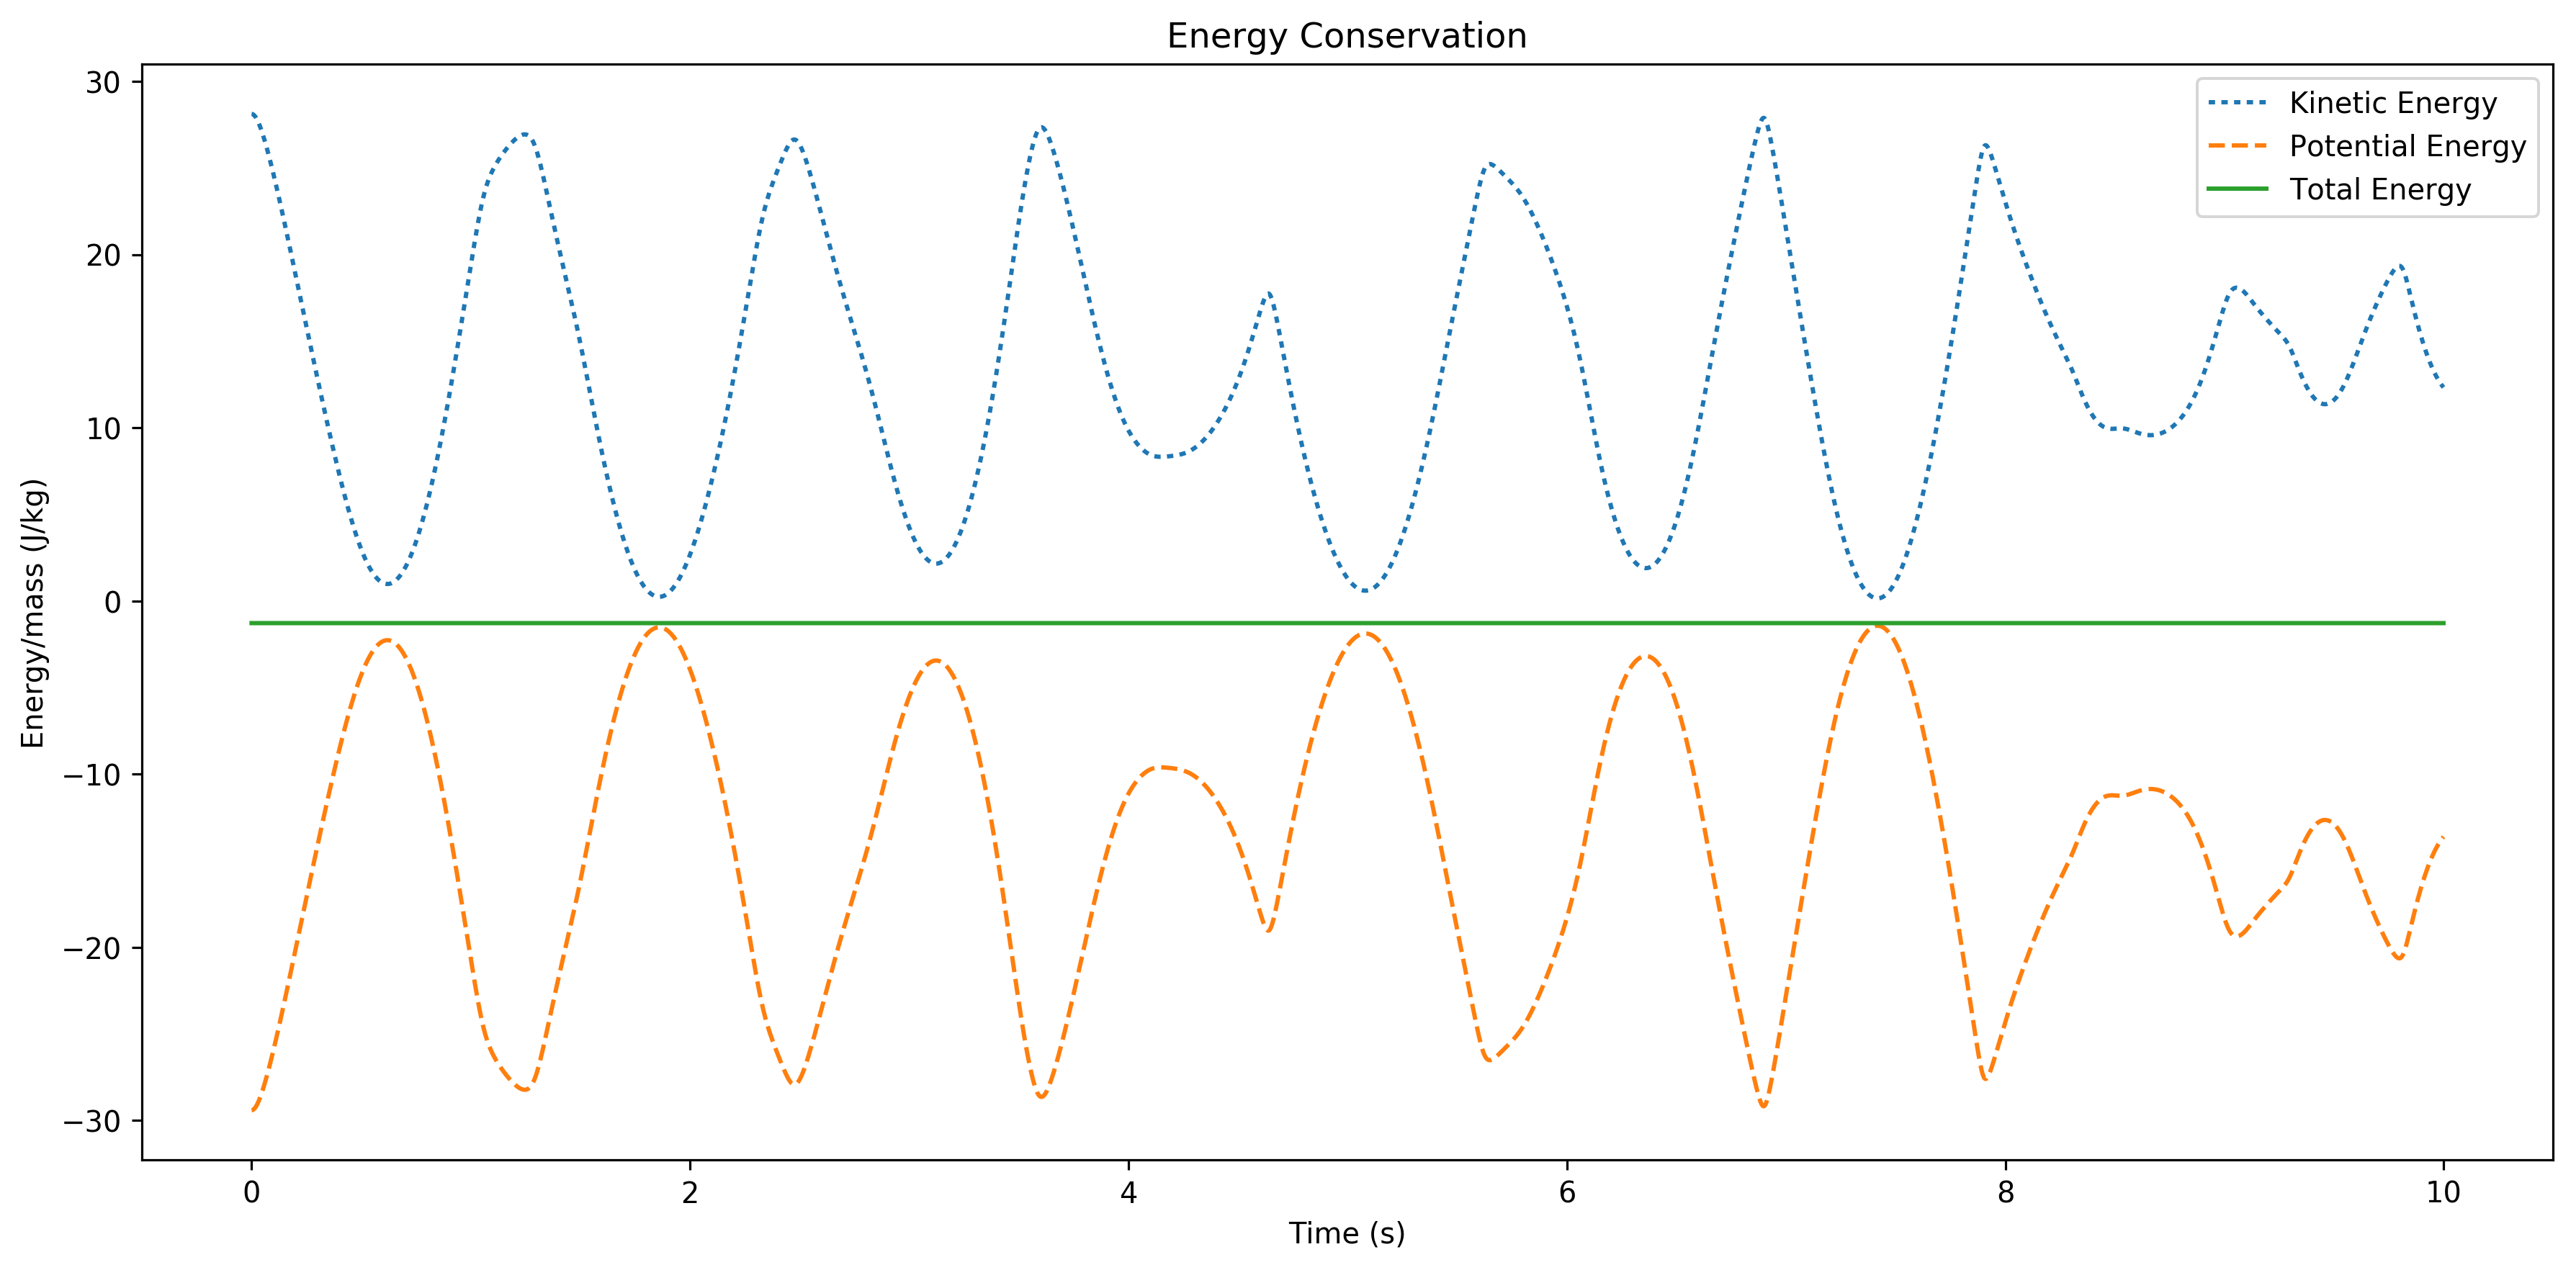

In [39]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 15], tmax = 10)

time_plot(solution, "Moderate Intial Velocity of Third Pendulum")
trajectory_plot(solution, "Moderate Intial Velocity of Third Pendulum")
phase_space_plot(solution, "Moderate Intial Velocity of Third Pendulum")

# Energy conservation (cancelling common factor of m)
t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution

U = -g*l*(3*cos(phi_1) + 2*cos(phi_2) + cos(phi_3))
T = (1/2)*l**2 * (3*dphi_1**2 + 2*dphi_2**2 + dphi_3**2 + 4*dphi_1*dphi_2*cos(phi_1-phi_2) 
                  + 2*dphi_2*dphi_3*cos(phi_2-phi_3) + 2*dphi_1*dphi_3*cos(phi_1-phi_3))
E = T + U 

figure()
plot(t, T, ":", label="Kinetic Energy")
plot(t, U, "--", label="Potential Energy")
plot(t, E, "-", label="Total Energy")

title("Energy Conservation")
xlabel("Time (s)")
ylabel("Energy/mass (J/kg)")

legend();

(0, 20)

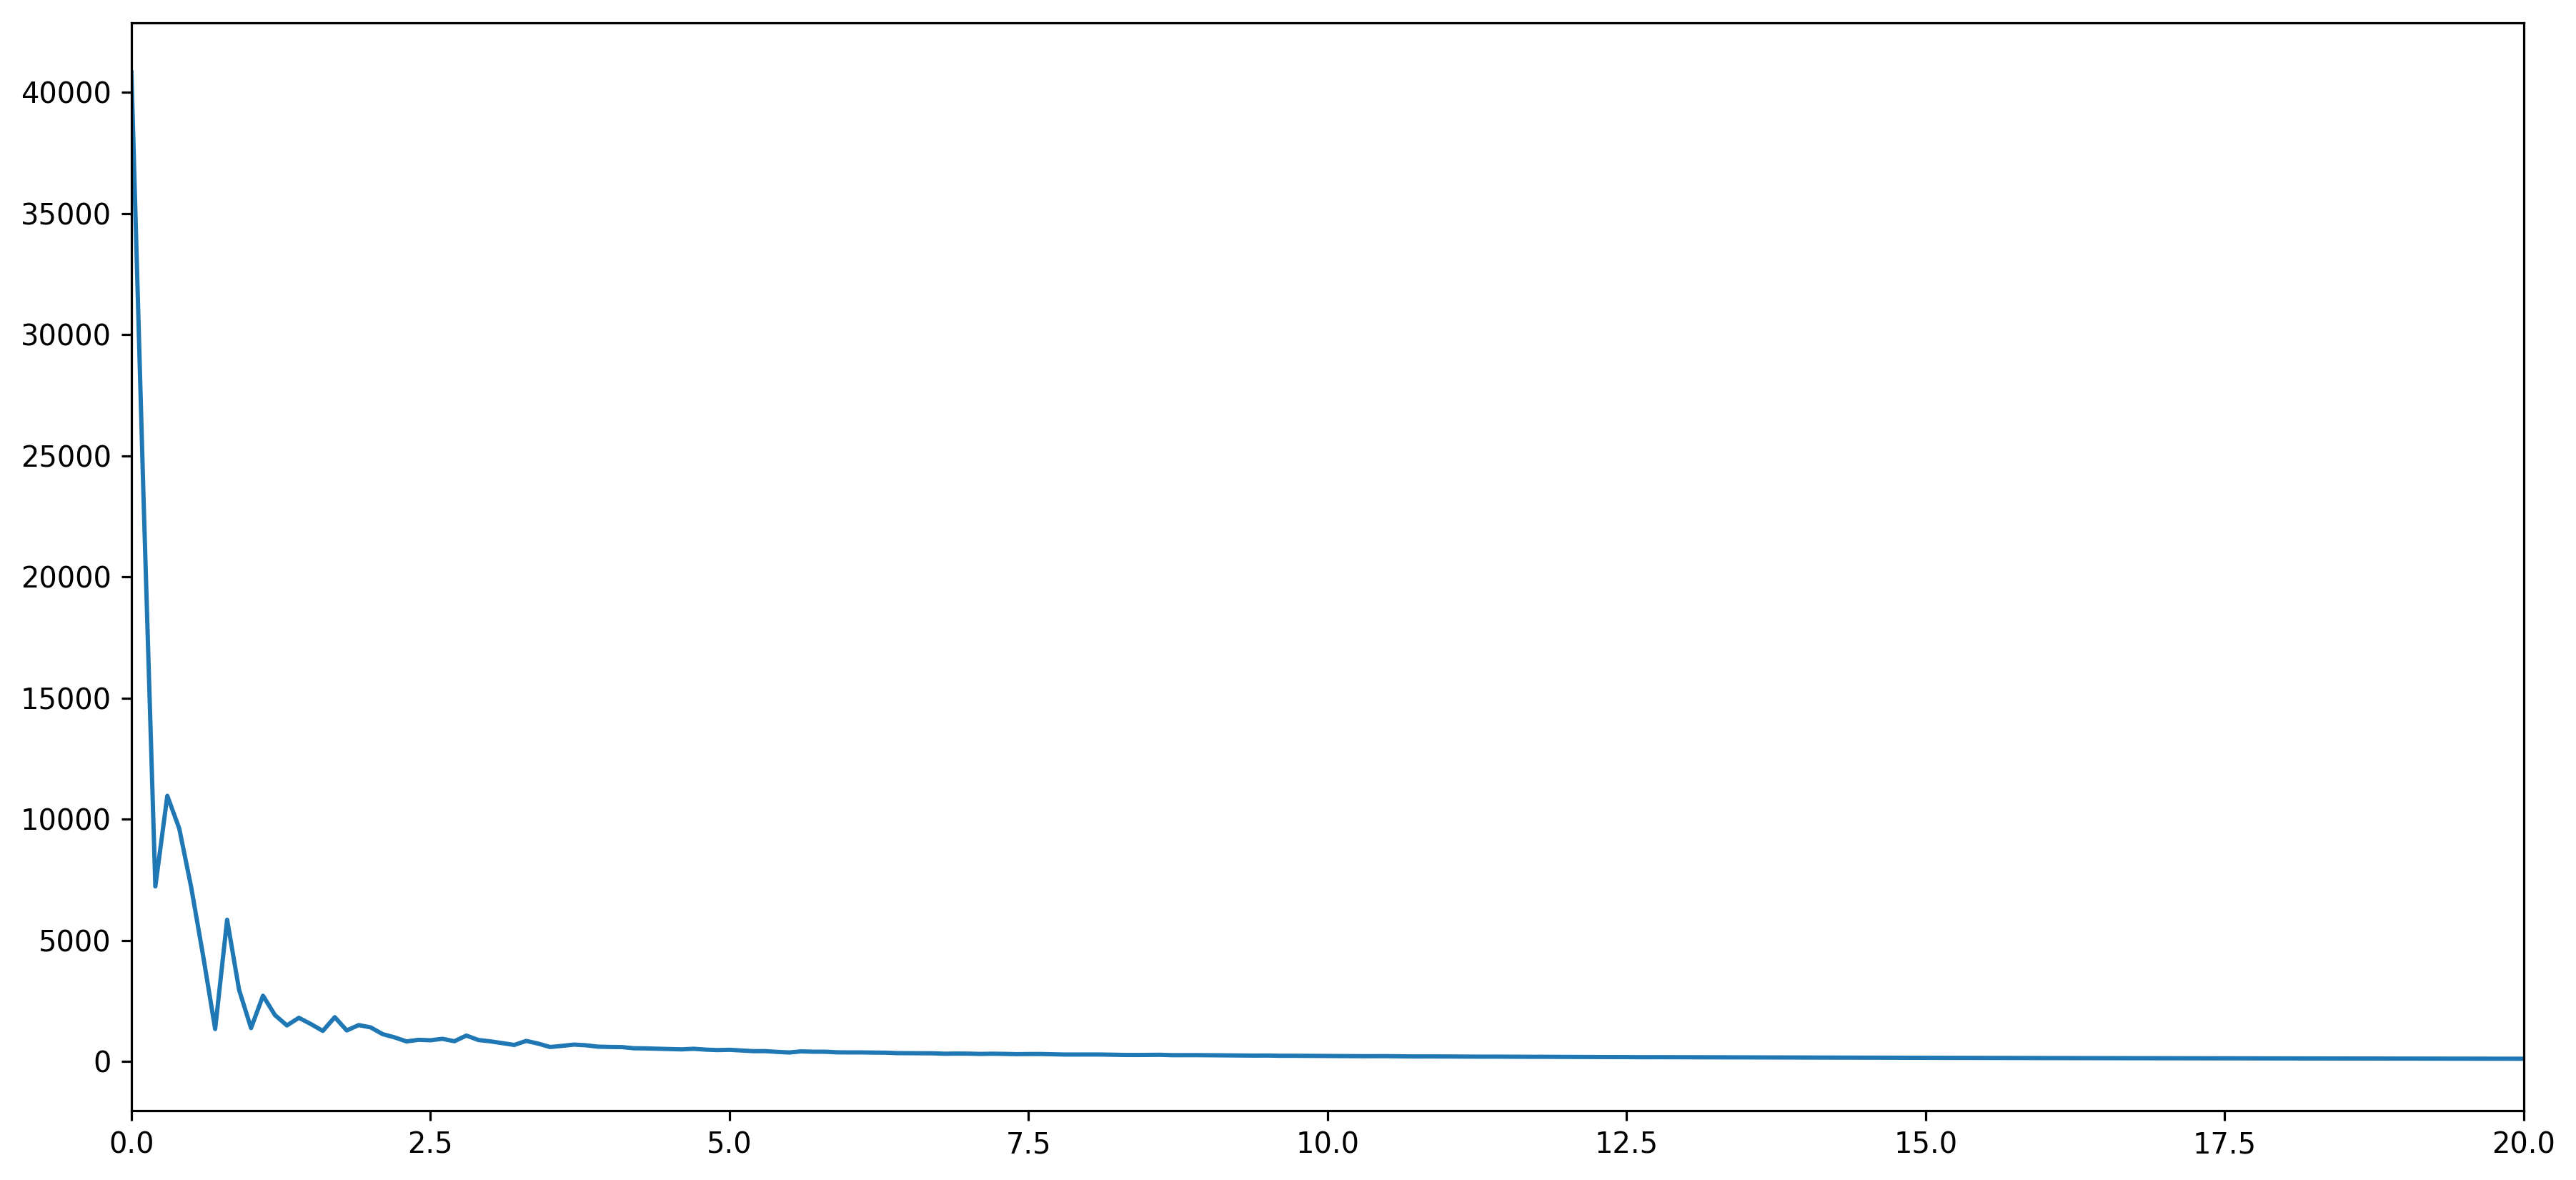

In [43]:
fft_3 = fft.rfft(phi_3)
#fft_2 = fft.fft(phi_2)
#fft_3 = fft.fft(phi_3)

#absolute(fft_1)[-100:]

dt = t[1] - t[0]
freqs = fft.rfftfreq(len(phi_1), dt)

plot(freqs, absolute(fft_3))
xlim(0, 20)
#plot(t, absolute(fft_2))
#plot(t, absolute(fft_3))

## Animation

It will be helpful to be able to visualize solutions if we can see them evolve in real time.

In [9]:
def animate(solution):
    %pylab 
    # get rid of inline plotting
    
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    time_per_frame = 1 #Each frame corresponds to a timestep of 1
    dstep = max(t) / size(t) #The integrator timestep size
    steps_per_frame = int(time_per_frame / dstep)  #Determine how many of the integrator steps per frame
    num_frames = int(max(t) / time_per_frame)
    print(num_frames)
    
    x1 = sin(phi_1)
    x2 = x1 + sin(phi_2)
    x3 = x2 + sin(phi_3)
    y1 = -cos(phi_1)
    y2 = y1 - cos(phi_2)
    y3 = y2 - cos(phi_3)
    
    
    fig = figure()
    ax = axes(xlim=[-3.5, 3.5], ylim=[-3.5, 3.5])
    grid()
    
    # initialize plotting of the positions of the masses
    m1_position, = ax.plot([], [], 'go-', ms=6)
    m2_position, = ax.plot([], [], 'mo-', ms=6)
    m3_position, = ax.plot([], [], 'ko-', ms=6)
    
    def init():
        m1_position.set_data([], [])
        m2_position.set_data([], [])
        m3_position.set_data([], [])
        return m1_position, m2_position, m3_position

    def animate_step(i):
        j = i*steps_per_frame
        print(j)
             
        m1_position.set_data([0,x1[j]], [0,y1[j]])
        m2_position.set_data([x1[j],x2[j]], [y1[j],y2[j]])
        m3_position.set_data([x2[j],x3[j]], [y2[j],y3[j]])
        
        return m1_position, m2_position, m3_position
    print('here')
    anim = animation.FuncAnimation(fig, animate_step, init_func=init, frames=num_frames, blit=True)
    
    

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
19
here


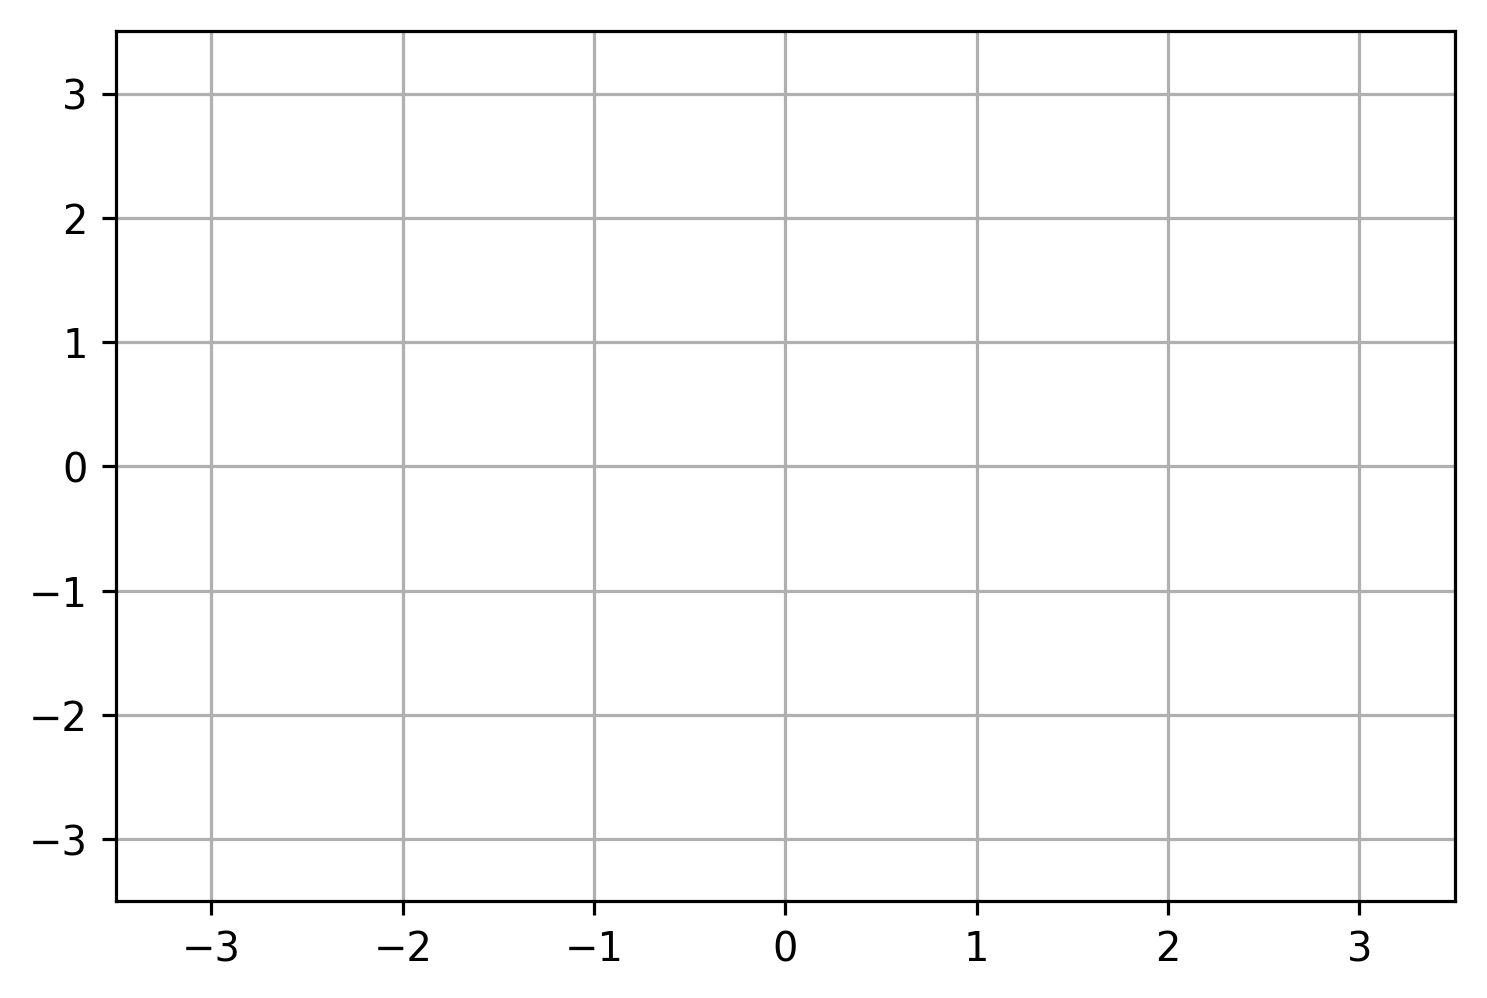

In [10]:
animate(solution)